In [235]:
from portiloop_software.portiloop_python.ANN.utils import get_configs
from portiloop_software.portiloop_python.ANN.data.moda_data import SignalDataset

config = get_configs("Test", False, 0) 
len_segment = config['len_segment_s'] * config['fe']   
filename = config['filename_classification_dataset'] if config['classification'] else config['filename_regression_dataset']    
ds_train = SignalDataset(filename=filename,
    path=config['path_dataset'],
    window_size=config['window_size'],
    fe=config['fe'],
    seq_len=config['seq_len'],
    seq_stride=config['seq_stride'],
    list_subject=[('01-05-0023', 279, 280)],
    len_segment=len_segment,
    threshold=config['threshold'])

In [236]:
data_moda = ds_train.data[0]

In [237]:
spindles_moda = ds_train.data[3]

In [238]:
spindles_moda

array([-1., -1., -1., ..., -2., -2., -2.])

In [239]:
spindles_moda = spindles_moda[15*250:-15*250]

In [240]:
spindles_moda.sum()

1744.0

In [201]:
from portiloop_software.portiloop_python.ANN.data.mass_data import read_pretraining_dataset, read_spindle_trains_labels, MassDataset

subjects = ['01-03-0003']
data = read_pretraining_dataset(config['MASS_dir'], patients_to_keep=subjects)
labels = read_spindle_trains_labels(config['old_dataset']) 
dataset = MassDataset(subjects, data, labels, config)

Shuffling took 0.022706985473632812 seconds
Number of spindle labels: 58096


In [202]:
start = (3414.9609 - 15)
end = (3414.9609 + 130)
data_mass = dataset.full_signal[int(start * 250):int(end*250)]

In [203]:
spindles_mass = dataset.full_labels[int(start * 250):int(end*250)]

In [204]:
spindles_mass = spindles_mass[15*250:-15*250]

In [205]:
spindles_mass.sum()

tensor(407)

In [206]:
import matplotlib.pyplot as plt

In [207]:
import numpy as np
from scipy.signal import firwin

def shift_numpy(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

class FIR:
    def __init__(self, nb_channels, coefficients, buffer=None):
        
        self.coefficients = np.expand_dims(np.array(coefficients), axis=1)
        self.taps = len(self.coefficients)
        self.nb_channels = nb_channels
        self.buffer = np.array(buffer) if buffer is not None else np.zeros((self.taps, self.nb_channels))
    
    def filter(self, x):
        self.buffer = shift_numpy(self.buffer, 1, x)
        filtered = np.sum(self.buffer * self.coefficients, axis=0)
        return filtered

    
class FilterPipeline:
    def __init__(self,
                 nb_channels,
                 sampling_rate,
                 power_line_fq=60,
                 use_custom_fir=False,
                 custom_fir_order=20,
                 custom_fir_cutoff=30,
                 alpha_avg=0.1,
                 alpha_std=0.001,
                 epsilon=0.000001,
                 filter_args=[]):
        if len(filter_args) > 0:
            use_fir, use_notch, use_std = filter_args
        else:
            use_fir=True,
            use_notch=False,
            use_std=True
        self.use_fir = use_fir
        self.use_notch = use_notch
        self.use_std = use_std
        self.nb_channels = nb_channels
        assert power_line_fq in [50, 60], f"The only supported power line frequencies are 50 Hz and 60 Hz"
        if power_line_fq == 60:
            self.notch_coeff1 = -0.12478308884588535
            self.notch_coeff2 = 0.98729186796473023
            self.notch_coeff3 = 0.99364593398236511
            self.notch_coeff4 = -0.12478308884588535
            self.notch_coeff5 = 0.99364593398236511
        else:
            self.notch_coeff1 = -0.61410695998423581
            self.notch_coeff2 =  0.98729186796473023
            self.notch_coeff3 = 0.99364593398236511
            self.notch_coeff4 = -0.61410695998423581
            self.notch_coeff5 = 0.99364593398236511
        self.dfs = [np.zeros(self.nb_channels), np.zeros(self.nb_channels)]
        
        self.moving_average = None
        self.moving_variance = np.zeros(self.nb_channels)
        self.ALPHA_AVG = alpha_avg
        self.ALPHA_STD = alpha_std
        self.EPSILON = epsilon
        
        if use_custom_fir:
            self.fir_coef = firwin(numtaps=custom_fir_order+1, cutoff=custom_fir_cutoff, fs=sampling_rate)
        else:
            self.fir_coef = [
                0.001623780150148094927192721215192250384,
                0.014988684599373741992978104065059596905,
                0.021287595318265635502275046064823982306,
                0.007349500393709578957568417933998716762,
                -0.025127515717112181709014251396183681209,
                -0.052210507359822452833064687638398027048,
                -0.039273839505489904766477593511808663607,
                0.033021568427940004020193498490698402748,
                0.147606943281569008563636202779889572412,
                0.254000252034505602516389899392379447818,
                0.297330876398883392486283128164359368384,
                0.254000252034505602516389899392379447818,
                0.147606943281569008563636202779889572412,
                0.033021568427940004020193498490698402748,
                -0.039273839505489904766477593511808663607,
                -0.052210507359822452833064687638398027048,
                -0.025127515717112181709014251396183681209,
                0.007349500393709578957568417933998716762,
                0.021287595318265635502275046064823982306,
                0.014988684599373741992978104065059596905,
                0.001623780150148094927192721215192250384]
        self.fir = FIR(self.nb_channels, self.fir_coef)
        
    def filter(self, value):
        """
        value: a numpy array of shape (data series, channels)
        """
        for i, x in enumerate(value):  # loop over the data series
            # FIR:
            if self.use_fir:
                x = self.fir.filter(x)
            # notch:
            if self.use_notch:
                denAccum = (x - self.notch_coeff1 * self.dfs[0]) - self.notch_coeff2 * self.dfs[1]
                x = (self.notch_coeff3 * denAccum + self.notch_coeff4 * self.dfs[0]) + self.notch_coeff5 * self.dfs[1]
                self.dfs[1] = self.dfs[0]
                self.dfs[0] = denAccum
            # standardization:
            if self.use_std:
                if self.moving_average is not None:
                    delta = x - self.moving_average
                    self.moving_average = self.moving_average + self.ALPHA_AVG * delta
                    self.moving_variance = (1 - self.ALPHA_STD) * (self.moving_variance + self.ALPHA_STD * delta**2)
                    moving_std = np.sqrt(self.moving_variance)
                    x = (x - self.moving_average) / (moving_std + self.EPSILON)
                else:
                    self.moving_average = x
            value[i] = x
        return value

In [208]:
filtering = FilterPipeline(1, 250)

In [209]:
data_filtered_mass = [filtering.filter([point])[0].item() for point in data_mass]

In [210]:
data_filtered_mass

[-0.014304616063061205,
 -28.468185332184486,
 -26.649703045527303,
 -22.536132447554767,
 -12.915836107532575,
 7.645190708392544,
 19.464377158643906,
 13.064579278701139,
 -16.807110598622263,
 -26.318706293365207,
 -24.94591318889475,
 -22.5201735283347,
 -19.904799474081383,
 -17.298730442044118,
 -14.88110033287628,
 -12.836178534641839,
 -11.258196907803137,
 -10.104368454957417,
 -9.258772059109441,
 -8.604511142945634,
 -8.034281672962036,
 -7.448193751933473,
 -6.625630096028577,
 -5.354275371018707,
 -3.507404434158209,
 -1.130868590049715,
 1.4965710251016413,
 3.9225943884064893,
 5.730424753866947,
 6.757583326217588,
 7.12413143192835,
 7.101742401714753,
 6.957128012931351,
 6.835878641624924,
 6.737170354042968,
 6.5818347646848245,
 6.324378667660958,
 5.99431673097981,
 5.646909678577131,
 5.3091162616969445,
 4.966920629351253,
 4.599573327753393,
 4.218986670370492,
 3.8596625399775575,
 3.564598392491662,
 3.3488668285109586,
 3.1643297547612104,
 2.90252949703651

In [231]:
# Get non 0 indexes in spindles
spindles_indexes = np.where(spindles_moda != 0)[0]

In [232]:
spindles_indexes

array([22625, 22626, 22627, 22628, 22629, 22630, 22631, 22632, 22633,
       22634, 22635, 22636, 22637, 22638, 22639, 22640, 22641, 22642,
       22643, 22644, 22645, 22646, 22647, 22648, 22649, 22650, 22651,
       22652, 22653, 22654, 22655, 22656, 22657, 22658, 22659, 22660,
       22661, 22662, 22663, 22664, 22665, 22666, 22667, 22668, 22669,
       22670, 22671, 22672, 22673, 22674, 22675, 22676, 22677, 22678,
       22679, 22680, 22681, 22682, 22683, 22684, 22685, 22686, 22687,
       22688, 22689, 22690, 22691, 22692, 22693, 22694, 22695, 22696,
       22697, 22698, 22699, 22700, 22701, 22702, 22703, 22704, 22705,
       22706, 22707, 22708, 22709, 22710, 22711, 22712, 22713, 22714,
       22715, 22716, 22717, 22718, 22719, 22720, 22721, 22722, 22723,
       22724, 22725, 22726, 22727, 22728, 22729, 22730, 22731, 22732,
       22733, 22734, 22735, 22736, 22737, 22738, 22739, 22740, 22741,
       22742, 22743, 22744, 22745, 22746, 22747, 22748, 22749, 22750,
       22751, 22752,

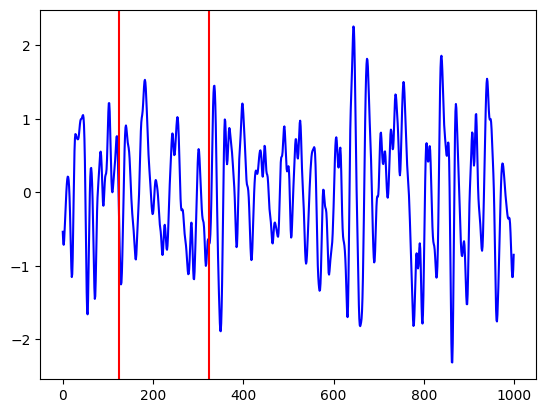

In [233]:
plt.plot(data_filtered_mass[22500:23500], color='blue')
# pltPLot a vertical line
plt.axvline(x=22625-22500, color='red')
plt.axvline(x=22824-22500, color='red')
plt.show()

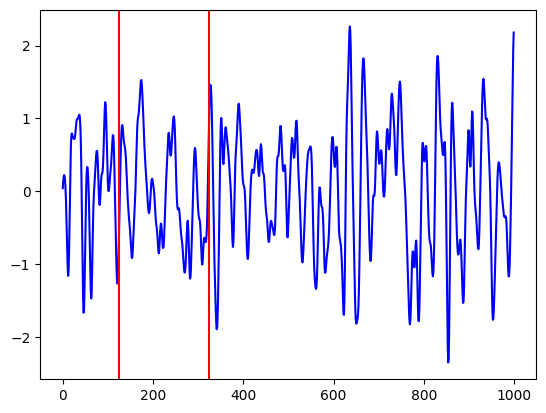

In [234]:
plt.plot(data_moda[22500:23500], color='blue')
# pltPLot a vertical line
plt.axvline(x=22625-22500, color='red')
plt.axvline(x=22824-22500, color='red')
plt.show()